# ClusterEnsemble demonstration
Some example usage of how to build up a dataframe of galaxy cluster properties, including NFW halo profiles. Each cluster is treated as an individual, meaning we track its individual mass and redshift, and other properties. This is useful for fitting a stacked weak lensing profile, for example, where you want to avoid fitting a single average cluster mass.

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from astropy import units
from matplotlib import pyplot as plt

#import seaborn as sns; sns.set() 

In [2]:
from clusters import ClusterEnsemble

### Create a ClusterEnsemble object by passing in a numpy array (or list) of redshifts

In [3]:
z = np.array([0.1,0.2,0.3])
c = ClusterEnsemble(z)
c.describe

'Ensemble of galaxy clusters and their properties.'

### Display what we have so far
Below the DataFrame (which so far only contains the cluster redshifts), we see the default assumptions for the power-law slope and normalization that will be used to convert richness $N_{200}$ to mass $M_{200}$. We'll see how to change those parameters below.

In [4]:
c.show()


Cluster Ensemble:


,z
0,0.1
1,0.2
2,0.3



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Add richness values to the dataframe
This step will also generate $M_{200}$, $r_{200}$, $c_{200}$, scale radius $r_s$, and other parameters, assuming the scaling relation given below.

In [5]:
n200 = np.ones(3)*20.
c.n200 = n200
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.1,20,2.700000e+13,0.612222,5.821359,12329.828385,0.105168
1,0.2,20,2.700000e+13,0.591082,5.627032,11398.735247,0.105043
2,0.3,20,2.700000e+13,0.569474,5.426060,10482.820471,0.104952



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Access any column of the dataframe as an array
Notice that [astropy units](http://docs.astropy.org/en/stable/units/) are present for the appropriate columns.

In [6]:
print('z: \t', c.z)
print('n200: \t', c.n200)
print('r200: \t', c.r200)
print('m200: \t', c.m200)
print('c200: \t', c.c200)
print('rs: \t', c.rs)

z: 	 [ 0.1  0.2  0.3]
n200: 	 [ 20.  20.  20.]
r200: 	 [ 0.61222163  0.59108187  0.56947428] Mpc
m200: 	 [  2.70000000e+13   2.70000000e+13   2.70000000e+13] solMass
c200: 	 [ 5.82135877  5.62703234  5.42605953]
rs: 	 [ 0.10516817  0.10504327  0.10495172] Mpc


### If you don't want units, you can get just the values

In [7]:
c.r200.value

array([ 0.61222163,  0.59108187,  0.56947428])

### Or access the Pandas DataFrame directly

In [8]:
c.dataframe

,z,n200,m200,r200,c200,delta_c,rs
0,0.1,20,2.700000e+13,0.612222,5.821359,12329.828385,0.105168
1,0.2,20,2.700000e+13,0.591082,5.627032,11398.735247,0.105043
2,0.3,20,2.700000e+13,0.569474,5.426060,10482.820471,0.104952


### Change the redshifts
These changes will propogate to all redshift-dependant cluster attributes.

In [9]:
c.z = np.array([0.4,0.5,0.6])
c.dataframe

,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,20,2.700000e+13,0.526483,5.041283,8859.107775,0.104434
2,0.6,20,2.700000e+13,0.505701,4.864887,8170.244874,0.103949


### Change the mass or richness values
Changing mass will affect richness and vice-versa, through the mass-richness scaling relation. These changes will propogate to all mass-dependant cluster attributes, as appropriate. 

In [10]:
c.m200 = [3e13,2e14,1e15]
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,21.563235,3.000000e+13,0.567408,5.179473,9422.926285,0.109549
1,0.5,83.602673,2.000000e+14,1.026296,4.226788,5956.926025,0.242808
2,0.6,263.927382,1.000000e+15,1.685668,3.573643,4117.417113,0.471695



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


In [11]:
c.n200 = [20,30,40]
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,30,4.763120e+13,0.636151,4.795641,7909.142281,0.132652
2,0.6,40,7.125343e+13,0.698834,4.477974,6777.240275,0.156060



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Change the parameters in the mass-richness relation
The mass-richness slope and normalization can both be changed. The new parameters will be applied to the current n200, and will propagate to mass and other dependant quantities.

In [12]:
c.massrich_slope = 1.5
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,30,4.960217e+13,0.644807,4.778560,7845.536637,0.134938
2,0.6,40,7.636753e+13,0.715169,4.451545,6687.866844,0.160656



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


### Show basic table
Perhaps we don't want the fancy pandas formatting on our table, or maybe we're not working in the Jupyter notebook.

In [13]:
c.show(notebook = False)


Cluster Ensemble:
     z  n200          m200      r200      c200      delta_c        rs
0  0.4    20  2.700000e+13  0.547827  5.229151  9630.870869  0.104764
1  0.5    30  4.960217e+13  0.644807  4.778560  7845.536637  0.134938
2  0.6    40  7.636753e+13  0.715169  4.451545  6687.866844  0.160656

Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


## Calculate $\Sigma(r)$ and $\Delta\Sigma(r)$ for NFW model
First select the radial bins in units of Mpc.

In [14]:
rmin, rmax = 0.1, 5. #Mpc
nbins = 50
rbins = np.logspace(np.log10(rmin), np.log10(rmax), num = nbins)
#rbins

In [15]:
c.calc_nfw(rbins)

sigma = c.sigma_nfw
deltasigma = c.deltasigma_nfw

In [16]:
sigma

<Quantity [[  1.39367876e+02,  1.26663035e+02,  1.14815477e+02,
              1.03805742e+02,  9.36101700e+01,  8.42013230e+01,
              7.55484460e+01,  6.76179810e+01,  6.03741370e+01,
              5.37794370e+01,  4.77952470e+01,  4.23823420e+01,
              3.75013710e+01,  3.31133390e+01,  2.91799890e+01,
              2.56641680e+01,  2.25301110e+01,  1.97436760e+01,
              1.72725260e+01,  1.50862520e+01,  1.31564500e+01,
              1.14567540e+01,  9.96283900e+00,  8.65237900e+00,
              7.50499500e+00,  6.50216600e+00,  5.62714400e+00,
              4.86484000e+00,  4.20171900e+00,  3.62567700e+00,
              3.12593500e+00,  2.69291700e+00,  2.31814600e+00,
              1.99413500e+00,  1.71429100e+00,  1.47282000e+00,
              1.26464200e+00,  1.08531500e+00,  9.30957000e-01,
              7.98187000e-01,  6.84060000e-01,  5.86018000e-01,
              5.01843000e-01,  4.29612000e-01,  3.67661000e-01,
              3.14550000e-01,  2.6903800

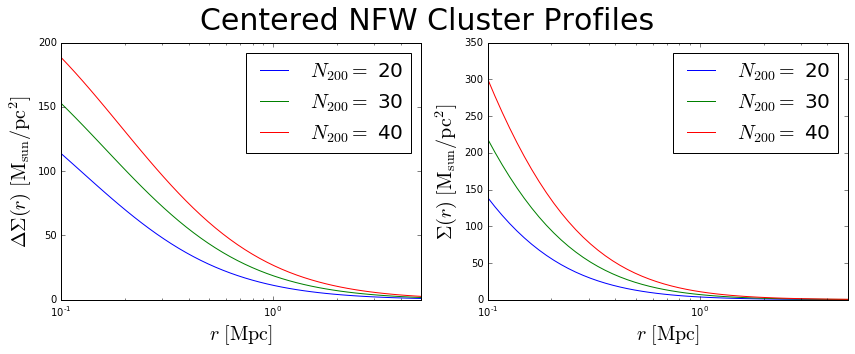

In [17]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Centered NFW Cluster Profiles', size=30)

first = fig.add_subplot(1,2,1)
second = fig.add_subplot(1,2,2)

for rich, profile in zip(c.n200,deltasigma):
    first.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
first.set_xscale('log')
first.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
first.set_ylabel('$\Delta\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', 
                 fontsize=20)
first.set_xlim(rbins.min(), rbins.max())
first.legend(fontsize=20)


for rich, profile in zip(c.n200,sigma):
    second.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
second.set_xscale('log')
second.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
second.set_ylabel('$\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', 
                 fontsize=20)
second.set_xlim(rbins.min(), rbins.max())
second.legend(fontsize=20)


fig.tight_layout()
plt.subplots_adjust(top=0.88)

# Calculate Miscentered NFW Profiles

When the true underlying dark matter distribution is offset from the assumed cluster "center" (such as a BCG or some other center proxy), the weak lensing profiles measured around the assumed centers will be different than for the perfectly centered case. One way to account for this is to describe the cluster centroid offsets as a Gaussian distribution around the true centers. We say the probability of an offset is given by

$P(R_\mathrm{off}) = \frac{R_\mathrm{off}}{\sigma_\mathrm{off}^2}e^{-\frac{1}{2}\left(\frac{R_\mathrm{off}}{\sigma_\mathrm{off}}\right)^2}$,

which is parameterized by the width of the 2D offset distribution $\sigma_\mathrm{off} = \sqrt{\sigma_x^2 + \sigma_y^2}$. Then the measured surface mass density is given by 

$\Sigma^\mathrm{sm}(R) = \int_0^\infty \Sigma(R | R_\mathrm{off})\  P(R_\mathrm{off})\ \mathrm{d}R_\mathrm{off}$,

where

$\Sigma(R | R_\mathrm{off}) = \frac{1}{2\pi} \int_0^{2\pi} \Sigma(r')\ \mathrm{d}\theta$, 

and

$r' = \sqrt{R^2 + R_\mathrm{off}^2 - R R_\mathrm{off} \cos{\theta}}$.

More details on the cluster miscentering problem can be found in [Ford et al 2015](http://arxiv.org/abs/1409.3571), [George et al 2012](http://arxiv.org/abs/1205.4262), and [Johnston et al 2007](http://arxiv.org/abs/0709.1159).

To calculate the miscentered profiles, simply create an array of offsets in units of Mpc, and pass it to the calc_nfw method:

In [18]:
offsets = np.array([0.1,0.1,0.1]) #same length as number of clusters

c.calc_nfw(rbins, offsets=offsets)

deltasigma_off = c.deltasigma_nfw
sigma_off = c.sigma_nfw

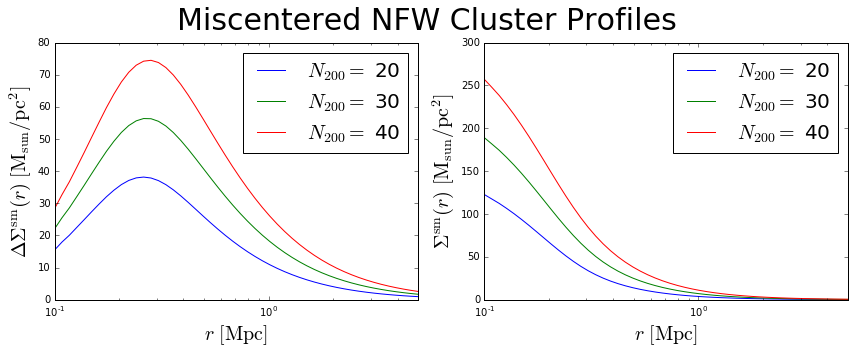

In [19]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Miscentered NFW Cluster Profiles', size=30)

first = fig.add_subplot(1,2,1)
second = fig.add_subplot(1,2,2)

for rich, profile in zip(c.n200,deltasigma_off):
    first.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
first.set_xscale('log')
first.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
first.set_ylabel('$\Delta\Sigma^\mathrm{sm}(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', fontsize=20)
first.set_xlim(rbins.min(), rbins.max())
first.legend(fontsize=20)


for rich, profile in zip(c.n200,sigma_off):
    second.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
second.set_xscale('log')
second.set_xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
second.set_ylabel('$\Sigma^\mathrm{sm}(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', 
                 fontsize=20)
second.set_xlim(rbins.min(), rbins.max())
second.legend(fontsize=20)


fig.tight_layout()
plt.subplots_adjust(top=0.88)

## NEW: a Python implentation of the NFW calculations 
Set the keyword parameter "use_c = False" to use Python only. Note that this method is significantly faster than the C code, for the perfectly centered case (because the C version suboptimally writes/reads to disc), but far slower for the miscentered case (which includes calculating a double integral). *Currently, the Python option calculates centered $\Sigma(r)$ and $\Delta\Sigma(r)$ profiles, and the miscentered profile $\Sigma^\mathrm{sm}(r)$, but not yet $\Delta\Sigma^\mathrm{sm}(r)$...*

In [20]:
c.calc_nfw(rbins, use_c = False)

sigma_py = c.sigma_nfw
dsigma_py = c.deltasigma_nfw

In [21]:
sigma_py = c.sigma_nfw
dsigma_py = c.deltasigma_nfw

In [22]:
#check the results match
np.testing.assert_allclose(sigma_py, sigma, rtol = 10**-4)
np.testing.assert_allclose(dsigma_py, deltasigma, rtol = 10**-4)

### Python Calculation of $\Sigma^\mathrm{sm}(r)$
Even with dblquad and large epsabs, epsrel allowances, this is way slow.

In [23]:
c.calc_nfw(rbins, offsets = offsets, use_c = False)

sigma_off_py = c.sigma_nfw
#deltasigma_off_py = c.deltasigma_nfw #not yet implemented

In [24]:
sigma_off_py

<Quantity [[  1.22374018e+02,  1.17498541e+02,  1.12254973e+02,
              1.06489371e+02,  1.00279726e+02,  9.36544500e+01,
              8.66925880e+01,  7.94855060e+01,  7.21706937e+01,
              6.48788822e+01,  5.77705279e+01,  5.09919602e+01,
              4.46682864e+01,  3.88932302e+01,  3.37187689e+01,
              2.91552780e+01,  2.51764803e+01,  2.17308902e+01,
              1.87580231e+01,  1.61976438e+01,  1.39882436e+01,
              1.20791326e+01,  1.04282169e+01,  9.00003209e+00,
              7.76440330e+00,  6.69547747e+00,  5.77099537e+00,
              4.97172529e+00,  4.28101098e+00,  3.68440325e+00,
              3.16935461e+00,  2.72496282e+00,  2.34175313e+00,
              2.01149187e+00,  1.72702580e+00,  1.48214293e+00,
              1.27145165e+00,  1.09027530e+00,  9.34560151e-01,
              8.00794972e-01,  6.85940738e-01,  5.87369109e-01,
              5.02808655e-01,  4.30297872e-01,  3.68144133e-01,
              3.14887882e-01,  2.6927141

In [25]:
sigma_off

<Quantity [[  1.22732961e+02,  1.17572618e+02,  1.12399498e+02,
              1.06567944e+02,  1.00366208e+02,  9.37419820e+01,
              8.67923190e+01,  7.95696890e+01,  7.22603480e+01,
              6.49443250e+01,  5.78179960e+01,  5.10279740e+01,
              4.46940890e+01,  3.89108810e+01,  3.37289760e+01,
              2.91605910e+01,  2.51793670e+01,  2.17318190e+01,
              1.87580240e+01,  1.61976430e+01,  1.39882430e+01,
              1.20791320e+01,  1.04282170e+01,  9.00003200e+00,
              7.76440300e+00,  6.69547700e+00,  5.77099500e+00,
              4.97172500e+00,  4.28101100e+00,  3.68440300e+00,
              3.16935400e+00,  2.72496300e+00,  2.34175300e+00,
              2.01149200e+00,  1.72702600e+00,  1.48214300e+00,
              1.27145200e+00,  1.09027500e+00,  9.34560000e-01,
              8.00795000e-01,  6.85941000e-01,  5.87369000e-01,
              5.02809000e-01,  4.30298000e-01,  3.68144000e-01,
              3.14888000e-01,  2.6927100

In [26]:
#check the results match... 
np.testing.assert_allclose(sigma_off_py, sigma_off, rtol = 10**-2)

#looks like 10**-2 is the level at which the offset profiles match

### Timing Comparisons: Python vs C
- For centered halos, Python implementation is about 30% faster than C.
- For offset halos, need $\Delta\Sigma^\mathrm{sm}(r)$ implemented in Python for full comparison... but just the $\Sigma^\mathrm{sm}(r)$ bit is about 3 times faster in C than in Python (for now).

In [27]:
time_c = %timeit -o c.calc_nfw(rbins)
time_py = %timeit -o c.calc_nfw(rbins, use_c = False)
time_offset_c = %timeit -o c.calc_nfw(rbins, offsets=offsets)
time_offset_py_justsigma = %timeit -o c.calc_nfw(rbins, \
    offsets = offsets, use_c = False)

100 loops, best of 3: 15 ms per loop
1000 loops, best of 3: 1.2 ms per loop
1 loops, best of 3: 1.28 s per loop
1 loops, best of 3: 4.08 s per loop


In [28]:
#Centered: Python vs C 
time_py.best / time_c.best

0.08016954168726777

In [29]:
#Miscentered: Python vs C 
time_offset_py_justsigma.best / time_offset_c.best

3.193659426506506

### To Do: 
- implement $\Delta\Sigma^\mathrm{sm}(r)$ in Python
- option to choose cofm relation & cosmology